Finance Fraud 

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "/Users/ishudev/Documents/Python/Synthetic_Financial_datasets_log.csv"  

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
display(df.describe(include="all").T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6362620.0,NaN,NaN,NaN,243.397246,142.331971,1.0,156.0,239.0,335.0,743.0
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6362620.0,NaN,NaN,NaN,179861.903549,603858.231463,0.0,13389.57,74871.94,208721.4775,92445516.64
nameOrig,6362620,6353307,C1902386530,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,6362620.0,NaN,NaN,NaN,833883.104074,2888242.673038,0.0,0.0,14208.0,107315.175,59585040.37
newbalanceOrig,6362620.0,NaN,NaN,NaN,855113.668579,2924048.502954,0.0,0.0,0.0,144258.41,49585040.37
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,6362620.0,NaN,NaN,NaN,1100701.66652,3399180.112994,0.0,0.0,132705.665,943036.7075,356015889.35
newbalanceDest,6362620.0,NaN,NaN,NaN,1224996.398202,3674128.94212,0.0,0.0,214661.44,1111909.25,356179278.92
isFraud,6362620.0,NaN,NaN,NaN,0.001291,0.035905,0.0,0.0,0.0,0.0,1.0


In [7]:
df.info()

print("\nTarget distribution (isFraud):")
print(df["isFraud"].value_counts(dropna=False))
print("\nFraud rate:", df["isFraud"].mean())

print("\nMissing values:")
display(df.isna().mean().sort_values(ascending=False).head(20))

print("\nTransaction types:")
print(df["type"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Target distribution (isFraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud rate: 0.001290820448180152

Missing values:


step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64


Transaction types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


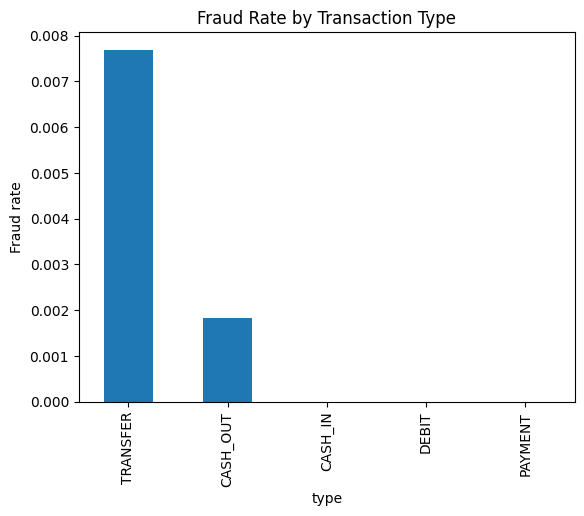

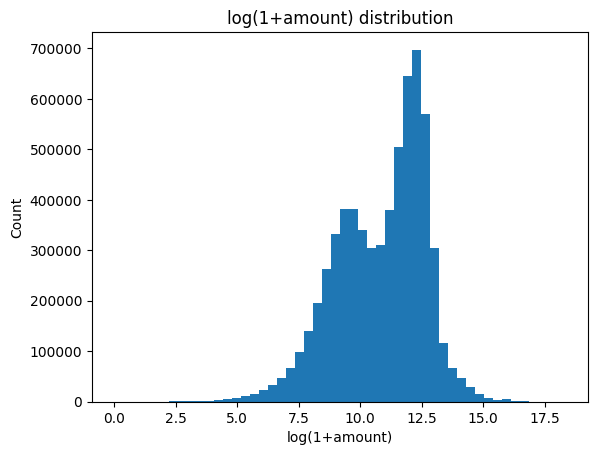

In [9]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)

plt.figure()
fraud_by_type.plot(kind="bar")
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud rate")
plt.show()


plt.figure()
plt.hist(np.log1p(df["amount"].astype(float)), bins=50)
plt.title("log(1+amount) distribution")
plt.xlabel("log(1+amount)")
plt.ylabel("Count")
plt.show()

In [ ]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    d = data.copy()

    
    d["orig_prefix"] = d["nameOrig"].str.slice(0, 1)
    d["dest_prefix"] = d["nameDest"].str.slice(0, 1)

    d["is_dest_merchant"] = (d["dest_prefix"] == "M").astype("int8")
    d["is_orig_customer"] = (d["orig_prefix"] == "C").astype("int8")

    d["org_balance_change"] = (d["newbalanceOrig"] - d["oldbalanceOrg"]).astype("float32")
    d["dest_balance_change"] = (d["newbalanceDest"] - d["oldbalanceDest"]).astype("float32")

    d["org_expected_change"] = (-d["amount"]).astype("float32")
    d["dest_expected_change"] = (d["amount"]).astype("float32")

   
    d["org_change_error"] = (d["org_balance_change"] - d["org_expected_change"]).abs().astype("float32")
    d["dest_change_error"] = (d["dest_balance_change"] - d["dest_expected_change"]).abs().astype("float32")

  
    d["orig_balance_zero_before"] = (d["oldbalanceOrg"] == 0).astype("int8")
    d["orig_balance_zero_after"] = (d["newbalanceOrig"] == 0).astype("int8")
    d["dest_balance_zero_before"] = (d["oldbalanceDest"] == 0).astype("int8")
    d["dest_balance_zero_after"] = (d["newbalanceDest"] == 0).astype("int8")

   
    d["is_transfer"] = (d["type"] == "TRANSFER").astype("int8")
    d["is_cash_out"] = (d["type"] == "CASH_OUT").astype("int8")

    d = d.drop(columns=["nameOrig", "nameDest", "orig_prefix", "dest_prefix"])

    return d

df_fe = add_features(df)
df_fe.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,is_dest_merchant,...,org_expected_change,dest_expected_change,org_change_error,dest_change_error,orig_balance_zero_before,orig_balance_zero_after,dest_balance_zero_before,dest_balance_zero_after,is_transfer,is_cash_out
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,...,-9839.639648,9839.639648,0.0,9839.639648,0,0,1,1,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,...,-1864.280029,1864.280029,0.0,1864.280029,0,0,1,1,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0,...,-181.000000,181.000000,0.0,181.000000,0,1,1,1,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0,...,-181.000000,181.000000,0.0,21363.000000,0,1,0,1,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,...,-11668.139648,11668.139648,0.0,11668.139648,0,0,1,1,0,0


In [13]:
df_fe = df_fe.sort_values("step").reset_index(drop=True)

target = "isFraud"


step_vals = df_fe["step"].values
q_train = np.quantile(step_vals, 0.70)
q_val   = np.quantile(step_vals, 0.85)

train_df = df_fe[df_fe["step"] <= q_train].copy()
val_df   = df_fe[(df_fe["step"] > q_train) & (df_fe["step"] <= q_val)].copy()
test_df  = df_fe[df_fe["step"] > q_val].copy()

print("Train:", train_df.shape, "Fraud rate:", train_df[target].mean())
print("Val  :", val_df.shape,   "Fraud rate:", val_df[target].mean())
print("Test :", test_df.shape,  "Fraud rate:", test_df[target].mean())

X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_val, y_val     = val_df.drop(columns=[target]), val_df[target]
X_test, y_test   = test_df.drop(columns=[target]), test_df[target]

Train: (4463587, 23) Fraud rate: 0.0008161597387930379
Val  : (980416, 23) Fraud rate: 0.0005752660095306482
Test : (918617, 23) Fraud rate: 0.004360903401526425


In [14]:
cat_cols = ["type"]  
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [16]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

gbm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.08,
        max_iter=300,
        random_state=42
    ))
])

models = {
    "LogReg (balanced)": log_reg,
    "GBM (HGBClassifier)": gbm
}

In [17]:
def evaluate_model(model, X_tr, y_tr, X_va, y_va, name="model"):
    model.fit(X_tr, y_tr)

    # Probabilities for thresholding
    p_va = model.predict_proba(X_va)[:, 1]

    roc = roc_auc_score(y_va, p_va)
    ap  = average_precision_score(y_va, p_va)  # PR-AUC

    print(f"\n{name}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC : {ap:.4f}")

    # Default threshold 0.5 predictions
    yhat = (p_va >= 0.5).astype(int)
    print("\nConfusion matrix @0.5:")
    print(confusion_matrix(y_va, yhat))
    print("\nReport @0.5:")
    print(classification_report(y_va, yhat, digits=4))

    return p_va

val_probs = {}
for nm, mdl in models.items():
    val_probs[nm] = evaluate_model(mdl, X_train, y_train, X_val, y_val, name=nm)


LogReg (balanced)
ROC-AUC: 0.9989
PR-AUC : 0.7488

Confusion matrix @0.5:
[[966639  13213]
 [    11    553]]

Report @0.5:
              precision    recall  f1-score   support

           0     1.0000    0.9865    0.9932    979852
           1     0.0402    0.9805    0.0772       564

    accuracy                         0.9865    980416
   macro avg     0.5201    0.9835    0.5352    980416
weighted avg     0.9994    0.9865    0.9927    980416


GBM (HGBClassifier)
ROC-AUC: 0.9592
PR-AUC : 0.9557

Confusion matrix @0.5:
[[979850      2]
 [    23    541]]

Report @0.5:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    979852
           1     0.9963    0.9592    0.9774       564

    accuracy                         1.0000    980416
   macro avg     0.9981    0.9796    0.9887    980416
weighted avg     1.0000    1.0000    1.0000    980416



In [18]:
def tune_threshold(y_true, y_prob, metric="f1"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1.0)  # align lengths

    if metric == "f1":
        f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
        best_idx = np.nanargmax(f1)
        return thresholds[best_idx], precision[best_idx], recall[best_idx], f1[best_idx]
    elif metric == "recall@precision":
        # Example: maximize recall with precision >= 0.20
        target_precision = 0.20
        valid = precision >= target_precision
        if valid.sum() == 0:
            return None
        best_idx = np.argmax(recall[valid])
        idx = np.where(valid)[0][best_idx]
        return thresholds[idx], precision[idx], recall[idx], None
    else:
        raise ValueError("Unknown metric")

for nm, probs in val_probs.items():
    thr, p, r, f1 = tune_threshold(y_val, probs, metric="f1")
    print(f"{nm} best F1 threshold = {thr:.4f} | precision={p:.4f} recall={r:.4f} f1={f1:.4f}")

LogReg (balanced) best F1 threshold = 0.9783 | precision=0.6703 recall=0.7535 f1=0.7095
GBM (HGBClassifier) best F1 threshold = 1.0000 | precision=0.9963 recall=0.9592 f1=0.9774


In [19]:
best_model_name = max(val_probs.keys(), key=lambda k: average_precision_score(y_val, val_probs[k]))
best_model = models[best_model_name]

# Fit on train+val, evaluate on test
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_trainval, y_trainval)
p_test = best_model.predict_proba(X_test)[:, 1]

print("Chosen model:", best_model_name)
print("Test ROC-AUC:", roc_auc_score(y_test, p_test))
print("Test PR-AUC :", average_precision_score(y_test, p_test))

# threshold from validation
thr, p, r, f1 = tune_threshold(y_val, val_probs[best_model_name], metric="f1")
yhat_test = (p_test >= thr).astype(int)

print("\nConfusion matrix @ tuned threshold:")
print(confusion_matrix(y_test, yhat_test))
print("\nReport @ tuned threshold:")
print(classification_report(y_test, yhat_test, digits=4))

Chosen model: GBM (HGBClassifier)
Test ROC-AUC: 0.9833229245056558
Test PR-AUC : 0.9410442148228686

Confusion matrix @ tuned threshold:
[[914441    170]
 [   188   3818]]

Report @ tuned threshold:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998    914611
           1     0.9574    0.9531    0.9552      4006

    accuracy                         0.9996    918617
   macro avg     0.9786    0.9764    0.9775    918617
weighted avg     0.9996    0.9996    0.9996    918617



In [21]:
# Only for logistic regression: get feature names and coefficients
if "LogReg" in best_model_name:
    pipe = best_model
    pre = pipe.named_steps["preprocess"]
    lr  = pipe.named_steps["model"]

    # Feature names after preprocessing
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    feat_names = num_cols + cat_names

    coefs = lr.coef_.ravel()
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    display(coef_df.sort_values("abs_coef", ascending=False).head(30))
else:
    print("Best model is not Logistic Regression; coefficient interpretability not available.")

Best model is not Logistic Regression; coefficient interpretability not available.


,split,train_step_max,test_step_range,test_size,test_fraud_rate,roc_auc,pr_auc
0,0,119,"(120, 183)",1069194,0.000644,0.999269,0.667694
1,1,183,"(184, 239)",1051850,0.000593,0.991102,0.949648
2,2,239,"(240, 306)",1076787,0.000697,0.995987,0.941732
3,3,306,"(307, 373)",1051462,0.000675,1.000000,0.999949
4,4,373,"(374, 743)",1047879,0.003863,0.990612,0.990280


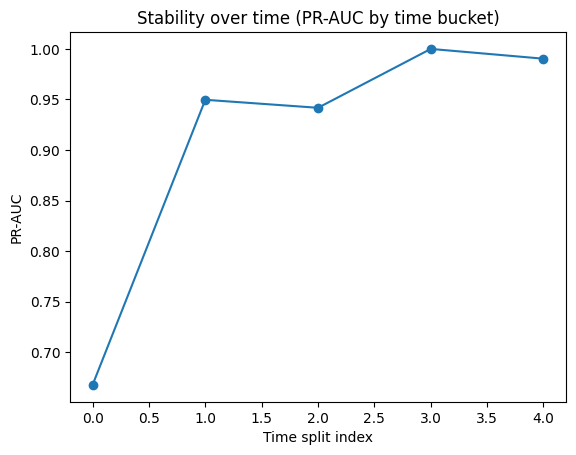

In [22]:
def rolling_time_splits_eval(model, df_all, target="isFraud", n_splits=5):
    df_all = df_all.sort_values("step").reset_index(drop=True)
    steps = df_all["step"].values
    edges = np.quantile(steps, np.linspace(0.0, 1.0, n_splits+1))

    results = []
    for i in range(n_splits-1):
        # Train: up to edge i+1, Test: next bucket
        train_mask = df_all["step"] <= edges[i+1]
        test_mask  = (df_all["step"] > edges[i+1]) & (df_all["step"] <= edges[i+2])

        tr = df_all[train_mask]
        te = df_all[test_mask]
        if te.shape[0] == 0:
            continue

        X_tr, y_tr = tr.drop(columns=[target]), tr[target]
        X_te, y_te = te.drop(columns=[target]), te[target]

        model.fit(X_tr, y_tr)
        p = model.predict_proba(X_te)[:, 1]

        results.append({
            "split": i,
            "train_step_max": int(edges[i+1]),
            "test_step_range": (int(edges[i+1])+1, int(edges[i+2])),
            "test_size": te.shape[0],
            "test_fraud_rate": float(y_te.mean()),
            "roc_auc": float(roc_auc_score(y_te, p)) if y_te.nunique() > 1 else np.nan,
            "pr_auc": float(average_precision_score(y_te, p)) if y_te.nunique() > 1 else np.nan,
        })

    return pd.DataFrame(results)

stability_df = rolling_time_splits_eval(best_model, df_fe, target="isFraud", n_splits=6)
display(stability_df)

plt.figure()
plt.plot(stability_df["split"], stability_df["pr_auc"], marker="o")
plt.title("Stability over time (PR-AUC by time bucket)")
plt.xlabel("Time split index")
plt.ylabel("PR-AUC")
plt.show()

In [23]:
def slice_eval(model, X, y, probs, slice_series, min_count=5000):
    out = []
    for val in slice_series.dropna().unique():
        mask = (slice_series == val)
        if mask.sum() < min_count:
            continue
        y_s = y[mask]
        p_s = probs[mask]
        if y_s.nunique() < 2:
            continue
        out.append({
            "slice": str(val),
            "count": int(mask.sum()),
            "fraud_rate": float(y_s.mean()),
            "roc_auc": float(roc_auc_score(y_s, p_s)),
            "pr_auc": float(average_precision_score(y_s, p_s))
        })
    return pd.DataFrame(out).sort_values("pr_auc", ascending=False)

# Recreate test probs with the chosen model already fit on train+val
p_test = best_model.predict_proba(X_test)[:, 1]

# Slice by transaction type (available in X_test)
slice_by_type = slice_eval(best_model, X_test, y_test, p_test, X_test["type"], min_count=20000)
display(slice_by_type)

# Slice by merchant destination (feature exists in engineered df; in X_test it is numeric column)
slice_by_merchant = slice_eval(best_model, X_test, y_test, p_test, X_test["is_dest_merchant"], min_count=20000)
display(slice_by_merchant)

,slice,count,fraud_rate,roc_auc,pr_auc
0,CASH_OUT,310302,0.006455,1.000000,1.000000
1,TRANSFER,80221,0.024969,0.981025,0.981257


,slice,count,fraud_rate,roc_auc,pr_auc
0,0,601180,0.006664,0.990514,0.99047


In [24]:
import joblib

MODEL_PATH = "fraud_model.pkl"
joblib.dump(best_model, MODEL_PATH)
print("Saved:", MODEL_PATH)

Saved: fraud_model.pkl
